In [1]:
import os
from os import listdir, path
from zipfile import ZipFile
import random
import numpy as np
import keras
from keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Unzip the data on disk

In [2]:
if not path.exists('data/cat/'):
    print('Extracting cat image files...')
    zf = ZipFile('data/cat.zip')
    zf.extractall('data/')
if not path.exists('data/dog/'):
    print('Extracting dog image files...')
    zf = ZipFile('data/dog.zip')
    zf.extractall('data/')

### Display utility functions

In [3]:
def show(image):
    plt.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
    plt.title("image shape: "+ str(image.shape), fontsize=14)
    plt.axis('off');
    
def show_multiple(images, figsize):
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for col, image in zip(ax, images):
        col.imshow(np.squeeze(image.astype("uint8")), cmap="gray")
        col.set_title("image shape: "+ str(image.shape), fontsize=14)
    plt.tight_layout()
    plt.axis('off');

# I - Introduction to Tensorflow and convolution filters

<img src="../images/standard_vs_depthwise_conv.png" style="width: 850px;"/>

**- Left: standard convolution, the whole kernel is parsing the input tensor for each output channel dimension**

**- Right: depthwise convolution, each slide of the kernel is parsing each input dimension. The result is constructed afterward using a concatenation of the feature maps. That is particularly useful to retrieve a valid RGB image**

#### Sample image example

In [4]:
sample_image = imread("data/panda.jpg")

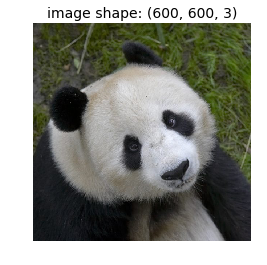

In [5]:
show(sample_image)

### I - A) Simple box blur kernel

#### Input placeholders

- The placeholder is a variable that doesn't have a value yet in the symbolic graph. The value will be fed when running the session by passing the `feed_dict` argument
- If the placeholder is a k-dimensional tensor, we need to specify its shape. 
- It is possible to leave the shape variable by putting `None` values in the shape

#### 2d convolution with tensorflow:
- https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d
- https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

In [6]:
def conv_2d(x, k, strides, padding, conv_type):
    if conv_type == 'depthwise':
        return tf.nn.depthwise_conv2d(
            x, k, strides=strides, padding=padding
        )
    elif conv_type == 'standard':
        return tf.nn.conv2d(
            x, k, strides=strides, padding=padding
        )   

In [7]:
def visualize_kernel(kernel):
    # move the channel dimension to the first one
    # this way, it is easier to see the spacial organization of the kernel with print
    print(np.transpose(kernel, (2, 0, 1)))

In [8]:
kernel_data = np.ones(shape=(5, 5, 3)).astype(np.float32)
kernel_data /= kernel_data.sum(0).sum(0)
visualize_kernel(kernel_data)

[[[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]]


Kernel shape: (5, 5, 3, 1)


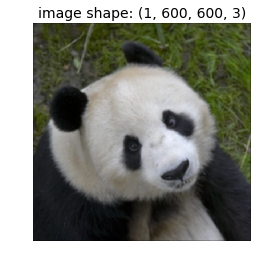

In [9]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 3)) # [batch, height, width, channels]
kernel = tf.placeholder(tf.float32, shape=(5, 5, 3, 1)) # [filter_height, filter_width, in_channels, out_channels]

output_image = conv_2d(image, kernel, strides=(1, 1, 1, 1), padding='SAME', conv_type='depthwise')

with tf.Session() as sess:
    image_batch_expanded = np.expand_dims(sample_image, axis=0)
    kernel_data_expanded = np.expand_dims(kernel_data, axis=-1)
    print('Kernel shape: %s' % str(kernel_data_expanded.shape))
    feed_dict = {image: image_batch_expanded, kernel: kernel_data_expanded}
    feature_map = sess.run(output_image, feed_dict=feed_dict)
    show(feature_map)

**Questions**
- Explain what happened here: what transformation has been applied to the image?

<span style="color:green">
Each kernel weight has the value $\frac{1}{height \cdot width}$.<br/>
Applying a 2D convolution with it will have an averaging effect: each value in the outputted feature map will be the average of the neighboring pixels in the input image.<br/>
This transformation in particular is called a box blur filter.
</span>

### I - B) Identity kernel

In [10]:
kernel_data = np.zeros(shape=(3, 3, 3)).astype(np.float32)
kernel_data[1, 1, :] = 1
visualize_kernel(kernel_data)

[[[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]]


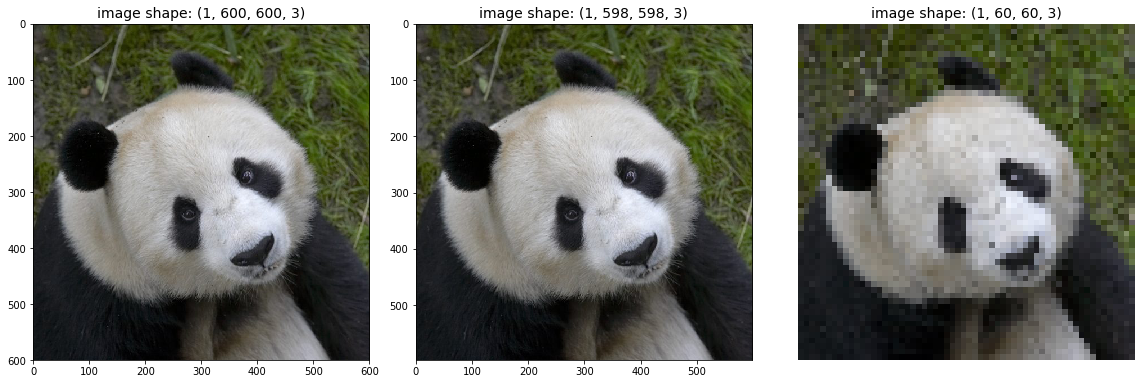

In [11]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 3))
kernel = tf.placeholder(tf.float32, shape=(3, 3, 3, 1))

output_same_padding = conv_2d(image, kernel, strides=(1, 1, 1, 1), 
                              padding='SAME', conv_type='depthwise')
output_valid_padding = conv_2d(image, kernel, strides=(1, 1, 1, 1), 
                               padding='VALID', conv_type='depthwise')
output_larger_strides = conv_2d(image, kernel, strides=(1, 10, 10, 1), 
                                padding='SAME', conv_type='depthwise')

with tf.Session() as sess:
    image_batch_expanded = np.expand_dims(sample_image, axis=0)
    kernel_data_expanded = np.expand_dims(kernel_data, axis=-1)
    feed_dict = {image: image_batch_expanded, kernel: kernel_data_expanded}
    feature_map_same_padding, feature_map_valid_padding, feature_map_larger_strides = sess.run(
            [output_same_padding, output_valid_padding, output_larger_strides], 
            feed_dict=feed_dict
    )
    show_multiple([
        feature_map_same_padding, 
        feature_map_valid_padding, 
        feature_map_larger_strides
    ], figsize=(16, 12))

**Questions**
- Try to modify the strides and the padding type. What are the effects on the final output?

<ul>
<li style="color:green">
Stride is the number of pixels with which we slide our filter, horizontally or vertically, while applying our convolution products. Increasing it has for main effect to decrease the final output size: in our case, having a $(10, 10)$ slide divides the final image shape by a factor of $10$ horizontally and $10$ vertically.<br/>
<li style="color:green">In addition, we can choose different padding types.<br/> 
The parameter 'SAME' results in an identical output shape for a minimal stride size, with $0$ values virtually added to the edges of the image proportionally to the kernel size.<br/> 
On the other hand, the parameter 'VALID' will lead to convolution operations being performed only if the kernel lies entirely over the image, contrary to the case with padding.
For instance, a convolution layer with (1,1) stride and this parameter will lead the final output size to have $K - 1$ fewer elements along both dimensions.
</ul>

### I - C) Line detection kernel on greyscale transformed image

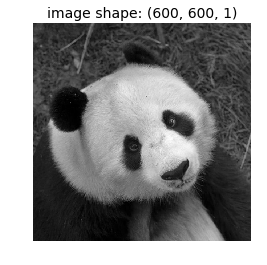

In [12]:
grey_sample_image = np.expand_dims(sample_image.sum(axis=2) / 3., axis=-1)
show(grey_sample_image)

**Exercice**

Try to implement a kernel that does line or edge detection:
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- https://en.wikipedia.org/wiki/Sobel_operator

In [13]:
line_detection_kernel_x = np.asarray(
    [
        [1, 0., -1],
        [2, 0., -2],
        [1, 0., -1]
    ]
)

line_detection_kernel_y = np.asarray(
    [
        [1,   2,  1],
        [0.,  0., 0.],
        [-1, -2,  -1]
    ]
)

kernel_data_x = np.expand_dims(line_detection_kernel_x, axis=-1)
kernel_data_y = np.expand_dims(line_detection_kernel_y, axis=-1)
print('Vertical edges detection kernel:')
visualize_kernel(kernel_data_x)
print('Horizontal edges detection kernel:')
visualize_kernel(kernel_data_y)

Vertical edges detection kernel:
[[[ 1.  0. -1.]
  [ 2.  0. -2.]
  [ 1.  0. -1.]]]
Horizontal edges detection kernel:
[[[ 1.  2.  1.]
  [ 0.  0.  0.]
  [-1. -2. -1.]]]


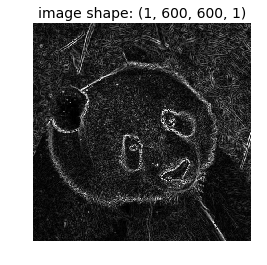

In [14]:
image = tf.placeholder(tf.float32, shape=(None, None, None, 1))
kernel = tf.placeholder(tf.float32, shape=(3, 3, 1, 1))

output_line_detection = conv_2d(image, kernel, strides=(1, 1, 1, 1), 
                                padding='SAME', conv_type='standard')

with tf.Session() as sess:
    image_batch = np.expand_dims(grey_sample_image, axis=0)
    kernel_data_x_expanded = np.expand_dims(kernel_data_x, axis=-1)
    kernel_data_y_expanded = np.expand_dims(kernel_data_y, axis=-1)
    feed_dict_x = {image: image_batch, kernel: kernel_data_x_expanded}
    feed_dict_y = {image: image_batch, kernel: kernel_data_y_expanded}
    feature_map_x = sess.run(output_line_detection, feed_dict=feed_dict_x)
    feature_map_y = sess.run(output_line_detection, feed_dict=feed_dict_y)
    show(np.sqrt(feature_map_x**2 + feature_map_y**2))

### I - D) Max and average pooling

**Exercice**

Now define a Max Pooling and an Average Pooling operations on our image.<br/>
Then apply it using a tf.Session
- https://www.tensorflow.org/api_docs/python/tf/nn/max_pool
- https://www.tensorflow.org/api_docs/python/tf/nn/avg_pool

Again, try to make fluctuate the `ksize` and `strides` parameters

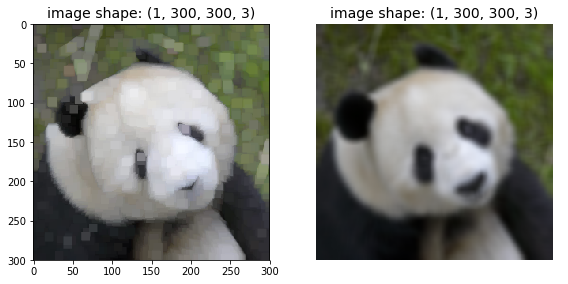

In [15]:
image = tf.placeholder(tf.float32, [None, None, None, 3])
output_max_pool = tf.nn.max_pool(
    image, ksize=[1, 20, 20, 1], strides=[1, 2, 2, 1], padding='SAME'
)
output_avg_pool = tf.nn.avg_pool(
    image, ksize=[1, 20, 20, 1], strides=[1, 2, 2, 1], padding='SAME'
)

with tf.Session() as sess:
    feed_dict={image:[sample_image]}
    feature_map_max_pool, feature_map_avg_pool = sess.run(
        [output_max_pool, output_avg_pool], feed_dict=feed_dict
    )
    show_multiple([feature_map_max_pool, feature_map_avg_pool], figsize=(8, 6))

# II - Training a ConvNet with Keras

### Utility functions

In [16]:
def get_splitted_data_with_size(image_size, sample_size, test_ratio, classes, seed):
    X, Y = [], []
    for label, animal in enumerate(classes):
        files = listdir(path.join('data', animal))
        random.shuffle(files)
        files = files[:(sample_size // len(classes))]
        for file in files:
            img = load_img(path.join('data', animal, file), 
                           target_size=image_size)
            X.append(img_to_array(img))
            Y.append(label)
    return train_test_split(np.asarray(X), np.asarray(Y), test_size=test_ratio, random_state=seed)

In [17]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for ax, metric, name in zip(axs, ['acc', 'loss'], ['Accuracy', 'Loss']):
        ax.plot(
            range(1, len(model_history.history[metric]) + 1), 
            model_history.history[metric]
        )
        ax.plot(
            range(1, len(model_history.history['val_' + metric]) + 1), 
            model_history.history['val_' + metric]
        )
        ax.set_title('Model ' + name)
        ax.set_ylabel(name)
        ax.set_xlabel('Epoch')
        ax.legend(['train', 'val'], loc='best')
    plt.show()

In [18]:
def scale_data(X_tr, X_val, return_scaler=False):
    shape_tr, shape_val = X_tr.shape, X_val.shape
    X_tr_flat = np.ravel(X_tr).reshape(-1, 1)
    X_val_flat = np.ravel(X_val).reshape(-1, 1)
    min_max_scaler = MinMaxScaler()
    X_tr_scaled = min_max_scaler.fit_transform(X_tr_flat).reshape(shape_tr)
    X_val_scaled = min_max_scaler.transform(X_val_flat).reshape(shape_val)
    if not return_scaler:
        return X_tr_scaled, X_val_scaled
    else:
        return X_tr_scaled, X_val_scaled, min_max_scaler
    
def apply_scaling(X, scaler):
    shape_X = X.shape
    X_flat = np.ravel(X).reshape(-1, 1)
    X_scaled = scaler.transform(X_flat).reshape(shape_X)
    return X_scaled

### II - A) Load, resize and scale the data

It is advised to fix a relatively small image_size, for instance (32, 32, 3), to avoid suffering from slow calculation

In [19]:
image_size = (32, 32, 3)

classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=10000, test_ratio=0.25, classes=classes, seed=42
)

In [20]:
X_tr.shape, X_val.shape, Y_tr.shape, Y_val.shape

((7500, 32, 32, 3), (2500, 32, 32, 3), (7500,), (2500,))

True label: dog


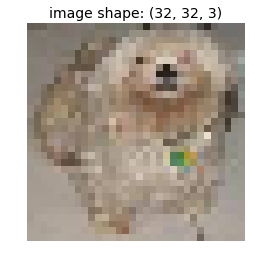

In [21]:
i = np.random.choice(len(X_tr))
show(X_tr[i])
print('True label: {0}'.format(classes[Y_tr[i]]))

In [22]:
X_tr_scaled, X_val_scaled, scaler = scale_data(X_tr, X_val, return_scaler=True)

### II - B) Design and train a ConvNet from scratch

**Exercice**

- Implement a Convolutional Network using the Keras Sequential API
- Typically, you would use series of convolutional blocs: 

`
model.add(Conv2D(output_filter, (kernel_height, kernel_width), padding, input_shape=(input_height, input_width, input_filter)))
model.add(Activation(activation))
model.add(BatchNormalization())
`
- Usually, the output_filter size grows accross the network
- End the network with a `Flatten` layer followed by a final `Dense` layer
- Be careful with the shapes accross the network, the activation functions used, the optimizer, and the loss function
- Don't forget to use Dropout layers to avoid overfitting issues

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

def design_and_compile_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model adds a loss function, optimiser and metrics to track during training
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [24]:
design_and_compile_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [25]:
batch_size = 128
num_epochs = 20  # The number of epochs (full passes through the data) to train for

model = design_and_compile_model()

# The fit function allows you to fit the compiled model to some training data
model_history = model.fit(
    x=X_tr_scaled, 
    y=Y_tr, 
    batch_size=batch_size, 
    epochs=num_epochs,
    verbose=1,
    validation_data=(X_val_scaled, Y_val)
)
print('Training complete')

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 54s 7ms/step - loss: 0.9140 - acc: 0.5931 - val_loss: 0.7312 - val_acc: 0.6396
Epoch 2/20
7500/7500 [==============================] - 51s 7ms/step - loss: 0.7208 - acc: 0.6495 - val_loss: 0.6141 - val_acc: 0.6968
Epoch 3/20
7500/7500 [==============================] - 45s 6ms/step - loss: 0.6472 - acc: 0.6809 - val_loss: 0.6797 - val_acc: 0.6652
Epoch 4/20
7500/7500 [==============================] - 46s 6ms/step - loss: 0.6087 - acc: 0.7084 - val_loss: 0.5257 - val_acc: 0.7432
Epoch 5/20
7500/7500 [==============================] - 50s 7ms/step - loss: 0.5423 - acc: 0.7419 - val_loss: 0.6422 - val_acc: 0.6972
Epoch 6/20
7500/7500 [==============================] - 46s 6ms/step - loss: 0.5391 - acc: 0.7436 - val_loss: 0.5960 - val_acc: 0.7212
Epoch 7/20
7500/7500 [==============================] - 45s 6ms/step - loss: 0.4873 - acc: 0.7675 - val_loss: 0.5202 - val_acc: 0.7644
Epoch 8

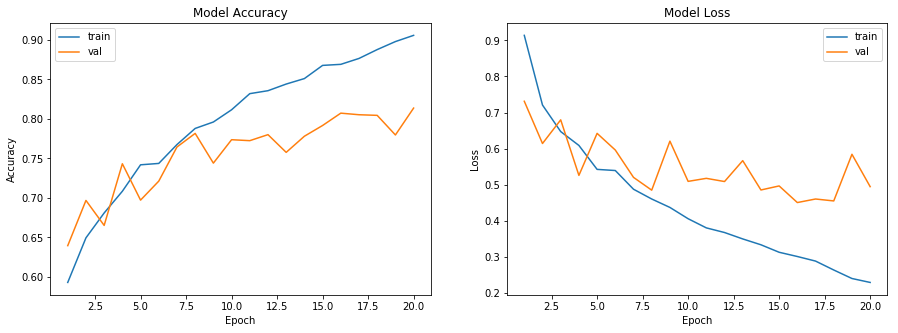

In [26]:
plot_model_history(model_history)

### II - C) Improve it using data augmentation

**Exercice**

- Try to improve the effectiveness of your network using some Data Augmentation
- Basically, it consists in building a `ImageDataGenerator` fitted on your training dataset
- Then you will be able to generate new consistent samples, and refit your model using the `fit_generator` Keras method

In [27]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=lambda x: apply_scaling(x, scaler)
    )
data_generator.fit(X_tr)

In [28]:
model = design_and_compile_model()

model_history = model.fit_generator(data_generator.flow(X_tr, Y_tr, batch_size=batch_size),\
                    steps_per_epoch=len(X_tr) // batch_size, epochs=20,\
                    verbose=1, validation_data=(apply_scaling(X_val, scaler), Y_val))

Epoch 1/20
58/58 [==============================] - 48s 819ms/step - loss: 0.9196 - acc: 0.5787 - val_loss: 0.9377 - val_acc: 0.6056
Epoch 2/20
58/58 [==============================] - 45s 782ms/step - loss: 0.7506 - acc: 0.6297 - val_loss: 0.7709 - val_acc: 0.6420
Epoch 3/20
58/58 [==============================] - 45s 780ms/step - loss: 0.6871 - acc: 0.6548 - val_loss: 0.8240 - val_acc: 0.6236
Epoch 4/20
58/58 [==============================] - 46s 786ms/step - loss: 0.6745 - acc: 0.6626 - val_loss: 0.7737 - val_acc: 0.6464
Epoch 5/20
58/58 [==============================] - 45s 781ms/step - loss: 0.6261 - acc: 0.6810 - val_loss: 0.6911 - val_acc: 0.6612
Epoch 6/20
58/58 [==============================] - 45s 784ms/step - loss: 0.6142 - acc: 0.6904 - val_loss: 0.5786 - val_acc: 0.7008
Epoch 7/20
58/58 [==============================] - 45s 780ms/step - loss: 0.5744 - acc: 0.7083 - val_loss: 0.7073 - val_acc: 0.6516
Epoch 8/20
58/58 [==============================] - 46s 785ms/step - 

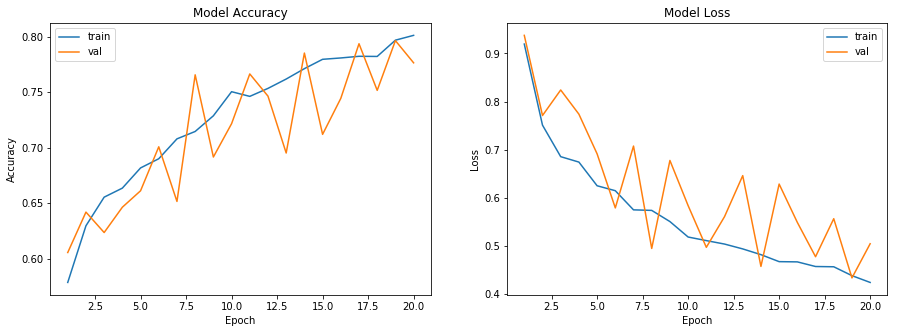

In [29]:
plot_model_history(model_history)

# III - Transfer learning

Objectives:
- Classify an image by loading a pre-trained ResNet50 model using Keras Zoo
    - No training required
    - Decode an ImageNet prediction
- Build a headless model and compute representations of images 
    - Retrain a model from representations of images for your own classification task: here cat vs dog dataset

In [30]:
cat_sample_path = "data/cat/cat_1.jpg"
dog_sample_path = "data/dog/dog_1.jpg"
resnet_input_size = (224, 224)

In [31]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### III - A) Classify of an image using pre-trained weights

**Exercise**
- Open an image, preprocess it and build a batch of 1 image
- Use the model to classify this image
- Decode the predictions using `decode_predictions` from Keras

Notes:
- You may use `preprocess_input` for preprocessing the image. 
- Test your code with `"data/cat/cat_1.jpg"` 
- ResNet has been trained on (width, height) images of (224,224) and range of pixel intensities in `[0, 255]`.
    - [skimage.transform.resize](http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize) has a `preserve_range` keyword useful in that matter 

Egyptian_cat 0.16768634
tiger_cat 0.12613273
bucket 0.1069751
tabby 0.07559398
hamper 0.053024054


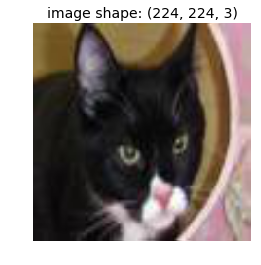

In [32]:
img = imread(cat_sample_path)
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

img_batch = preprocess_input(np.expand_dims(img_resized, axis=0)) 
predictions = model_ResNet50.predict(img_batch)
decoded_predictions = decode_predictions(predictions)

for _, name, score in decoded_predictions[0]:
    print(name, score)

### III - B) Build a headless model and compute representations of images

- Model has $177$ layers
- See where we should stop to have the extracted feature and start building a new classficlation model from here

In [33]:
print(len(model_ResNet50.layers))

177


- Let's remove the last dense classification layer that is specific 
to the image net classes and use the previous layers (after flattening) as a feature extractors
- Use ResNet input layer and last layer of extracted features to build a feature extractor model
    - Use Keras functional API

In [34]:
# Create a truncated Model using ResNet50.input and the before last layer
output = model_ResNet50.layers[-2].output
feat_extractor_model = Model(model_ResNet50.input, output)

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [35]:
def preprocess_resnet(x, size):
    x = resize(x, size, mode='reflect', preserve_range=True)
    x = np.expand_dims(x, axis=0)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

This model extracts high level concepts from any image that has been preprocessed like the images ResNet trained on.
The model transforms a preprocessed (224, 224) RGB image into a long vector of activations.
Each activation refers to some concept statistically connected to a bunch of different classes.

In [36]:
cat_img = imread(cat_sample_path)
cat_img_processed = preprocess_resnet(cat_img, resnet_input_size)
cat_representation = feat_extractor_model.predict(cat_img_processed)
print("Cat deep representation shape: (%d, %d)" % cat_representation.shape)
for activation in np.ravel(cat_representation):
    print(activation)

Cat deep representation shape: (1, 2048)
0.34350356
0.19915791
0.06703613
0.76575136
0.96197516
0.43958077
1.1953117
0.8787123
0.0
0.0
0.04407724
0.013433561
0.36671567
0.16505732
0.0031581242
0.10162338
0.0038361135
0.14693777
0.16209424
0.07163297
0.017126998
0.05176988
0.0
0.59034073
0.0
0.24374783
0.005026676
0.29086143
0.0
0.11508261
0.028935097
0.009024987
0.085664
0.21246873
0.80908406
0.026903862
0.026535233
2.1387246
0.0149168605
0.2218067
0.061434895
0.03246616
0.42332348
0.2409795
0.39451763
2.9844086
0.023346199
1.0177095
0.019286463
0.14721848
0.30015332
1.4108393
2.2675765
0.058628507
0.6885783
0.040647812
0.76785475
0.06555825
0.2491039
0.57439005
0.31917608
0.37031475
0.108021095
1.3426763
0.0075896615
0.0
0.1627914
0.24998493
2.3878691
0.12710474
0.0
0.06571979
0.0
0.8510599
0.0055761095
0.13157573
0.9000412
1.715128
0.008304771
1.051323
0.0023716202
1.0797511
0.8712255
0.21415977
0.09163103
0.68818265
1.080303
0.26982862
0.6595685
0.0
0.6965255
0.0
0.12181493
0.752614

**Questions**
- What is the number of $0$s in the cat representation vector ?

<span style="color:green">
$182$ zeros found in the cat representation vector. That is $8.89\%$ of all activations
</span>

- Can you find any negative values?

<span style="color:green">
No negative values found at this stage
</span>

- Why are there $0$ values ? What does it mean ?

<span style="color:green">
As mentioned above, each activation refers to some concept statistically connected to a bunch of different classes. A $0$ activation, or close to $0$, means that the high-level concept being looked for by the network in not found in the image
</span>

- Extract ResNet representations of other dogs and cats. Are the zeros at the same places in vector ?
    - Explain why or give an intuition of it

<span style="color:green">
Distributions of $0s$ activations are different for dogs and cats.  
That is because to make the difference between these $2$ classes there are concepts that are  specific to dogs or cats. That is concepts for which $p(dog|concept)\approx1$ and $p(cat|concept)\approx0$ or $p(cat|concept)\approx1$ and $p(dog|concept)\approx0$
Thus concepts likely to be there for a class and not the other, leading to $0$ activations at some indexes for a class and not the other
</span>

In [37]:
print("**Number of 0s in the cat representation vector**")
nb_zeros = sum(np.ravel(cat_representation) == 0)
print(nb_zeros, "zeros")
print("{:.2f}% of zeros".format(nb_zeros/float(len(np.ravel(cat_representation)))*100))

print("**Number of negative values in the cat representation vector**")
nb_negative_values = sum(np.ravel(cat_representation) < 0)
print(nb_negative_values, "negative values")

**Number of 0s in the cat representation vector**
182 zeros
8.89% of zeros
**Number of negative values in the cat representation vector**
0 negative values


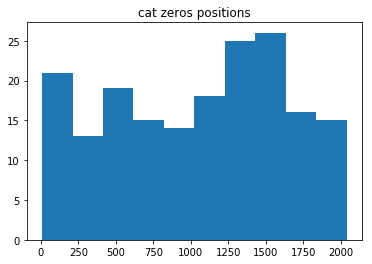

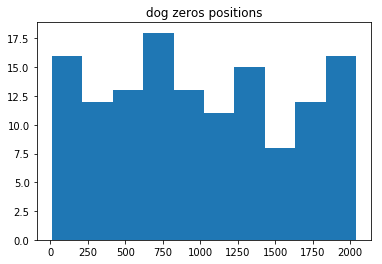

In [38]:
plt.hist(np.where(cat_representation == 0)[1])
plt.title("cat zeros positions")
plt.show()

dog_img = imread(dog_sample_path)
dog_img_processed = preprocess_resnet(dog_img, resnet_input_size)
dog_representation = feat_extractor_model.predict(dog_img_processed)

plt.hist(np.where(dog_representation == 0)[1])
plt.title("dog zeros positions")
plt.show()

### III - C) Retrain a model from computed representations of images

For this session we are going to use the dataset of the dogs-vs-cats we already used in part $2$.

In [39]:
classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=(224, 224, 3), sample_size=2000, test_ratio=0.25, classes=classes, seed=42
)

**Questions**
- Inference time takes a long time only for $2000$ images
    - Explain why it would be much faster using a GPU
    
<span style="color:green">
GPU allows to perform parallel computing.
Most of the work during inference is about computing convolutions. Each convolution operation in a convolution layer is independant from the others. That means its outcome doesn't depend on the outcome of the others. All convolution operations could theoretically be performed at the same time to produce the feature map. Thus convolution layers are highly parallelizable and suit GPU usage
</span>

In [40]:
X_extracted_tr = feat_extractor_model.predict(preprocess_input(X_tr), verbose=1)
X_extracted_val = feat_extractor_model.predict(preprocess_input(X_val), verbose=1)
print('Done extracting resnet50 features..')

500/500 [==============================] - 61s 121ms/step
Done extracting resnet50 features..


- Define a classification model fed with the newly created X and Y
    - Remember that X is now a set of ResNet representations of the images
- Use either functional of sequential Keras apis
- Display training and validation accuracies

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.optimizers import Adam

n_features = X_extracted_tr.shape[1]
transfer_model = Sequential()
transfer_model.add(Dropout(0.6))
transfer_model.add(Dense(1, input_dim=n_features, activation='sigmoid'))
transfer_model.compile(optimizer=Adam(),
                  loss='binary_crossentropy', metrics=['accuracy'])
transfer_model.fit(X_extracted_tr, Y_tr,
              validation_data=(X_extracted_val, Y_val),
              verbose=1, epochs=30)

Train on 1500 samples, validate on 500 samples
Epoch 1/30
1500/1500 [==============================] - 1s 854us/step - loss: 0.5902 - acc: 0.7287 - val_loss: 0.2098 - val_acc: 0.9320
Epoch 2/30
1500/1500 [==============================] - 0s 65us/step - loss: 0.2727 - acc: 0.8913 - val_loss: 0.1599 - val_acc: 0.9440
Epoch 3/30
1500/1500 [==============================] - 0s 66us/step - loss: 0.2670 - acc: 0.8840 - val_loss: 0.1642 - val_acc: 0.9340
Epoch 4/30
1500/1500 [==============================] - 0s 67us/step - loss: 0.2236 - acc: 0.9060 - val_loss: 0.1492 - val_acc: 0.9360
Epoch 5/30
1500/1500 [==============================] - 0s 66us/step - loss: 0.2181 - acc: 0.9033 - val_loss: 0.1401 - val_acc: 0.9360
Epoch 6/30
1500/1500 [==============================] - 0s 64us/step - loss: 0.1865 - acc: 0.9313 - val_loss: 0.1312 - val_acc: 0.9440
Epoch 7/30
1500/1500 [==============================] - 0s 66us/step - loss: 0.1711 - acc: 0.9253 - val_loss: 0.1377 - val_acc: 0.9340
Epoch 8

**Questions**
- How high in validation accuracy did you get ? 
- Compare to your previous classification model in part 2. Does it perform worse ? Better ? Why ?

<span style="color:green">
Compared to the previous model, this one performs much better. That is due to the concepts extracted by resnet. They are all relevant with respect to some classes, there are no concept looked for in the images that is pure noise. 
The extraction itself from resnet of the main concepts for our predictions task is of much better quality and generalizable since it has been obtained from training on a huge dataset of millions of images that match better the actual distribution
</span>

- Did you observe overfitting during training ? Why ? If yes, what did you do to avoid it ?
    
<span style="color:green">
Regularization techniques like dropout must be used to prevent the model from relying on data patterns only found in training set
</span>